In [1]:
%matplotlib inline
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font',size=18)
import matplotlib.ticker as plticker
import numpy as np
import warnings
import os.path


from hyperfet.devices import SCMOSFET,VO2,HyperFET, Direction
import hyperfet.approximations as appr
import hyperfet.extractions as extr
from hyperfet.references import si#, mixed_vo2_params
from hyperfet.fitting import show_transistor
from hyperfet import ABSTRACT_IMAGE_DIR

In [2]:
def ylog():
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        plt.yscale('log')
def tighten():
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        plt.tight_layout()

In [3]:
# Parameters given for Figure 3

vo2_params={
    "rho_m":si("3e-4 ohm cm"),
    "rho_i":si("30 ohm cm"),
    "J_MIT":si("1e6 A/cm^2"),
    "J_IMT":si(".5e4 A/cm^2"),
    "v_met": si(".05 V/ (20nm)")
}

#vo2=VO2(**vo2_params)

VDD=.5

In [4]:
opts={
    'figsize': (6,7),
    'linidvgpos': [.3,.68,.2,.2],
    'linidvgxticks': [0,.25,.5],
    'linidvgxlim': [0,.5],
    'linidvgyticks': [100,200,300],
    'linidvdpos': [.62,.25,.25,.3],
    'linidvdxticks': [0,.25,.5],
    'linidvdyticks': [0,100,200,300],
}

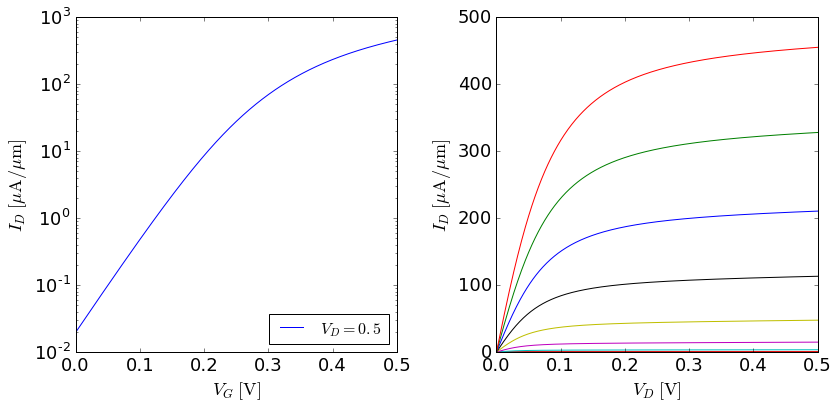

In [5]:
fet=None
@interact(VT0=FloatSlider(value=.32,min=0,max=1,step=.05,continuous_update=False),
          W=FloatSlider(value=100,min=10,max=100,step=10,continuous_update=False),
          Cinv_vxo=FloatSlider(value=2500,min=1000,max=5000,step=400,continuous_update=False),
          SS=FloatSlider(value=.070,min=.05,max=.09,step=.005,continuous_update=False),
          alpha=FloatSlider(value=2.5,min=0,max=5,step=.5,continuous_update=False),
          beta=FloatSlider(value=1.8,min=0,max=4,step=.1,continuous_update=False),
          VDD=FloatSlider(value=.5,min=.3,max=1,step=.05,continuous_update=False),
          VDsats=FloatSlider(value=.1,min=.1,max=2,step=.1,continuous_update=False),
          delta=FloatSlider(value=.01,min=0,max=.5,step=.05,continuous_update=False),
          log10Gleak=FloatSlider(value=-12,min=-14,max=-5,step=1,continuous_update=False)
         )
def show_HEMT(VT0,W,Cinv_vxo,SS,alpha,beta,VDsats,VDD,delta,log10Gleak):
    global fet
    plt.figure(figsize=(12,6))
    fet=SCMOSFET(
        W=W*1e-9,Cinv_vxo=Cinv_vxo,
        VT0=VT0,alpha=alpha,SS=SS,delta=delta,
        VDsats=VDsats,beta=beta,Gleak=10**log10Gleak)
    
    plt.subplot(121)
    VD=np.array(VDD)
    VG=np.linspace(0,.5,500)
    VDgrid,VGgrid=np.meshgrid(VD,VG)
    I=fet.ID(VD=VDgrid,VG=VGgrid)
    plt.plot(VG,I/fet.W,label=r"$V_D={:.2g}$".format(VDD))
    plt.yscale('log')
    plt.xlabel(r"$V_G\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    plt.legend(loc='lower right',fontsize=16)
    
    plt.subplot(122)
    VD=np.linspace(0,VDD,500)
    VG=np.linspace(0,VDD,10)
    VDgrid,VGgrid=np.meshgrid(VD,VG)
    I=fet.ID(VD=VDgrid,VG=VGgrid)
    plt.plot(VD,I.T/fet.W)
    plt.xlabel(r"$V_D\;\mathrm{[V]}$")
    plt.ylabel(r"$I_D\;\mathrm{[\mu A/\mu m]}$")
    #plt.legend([r"$V_G={:.2g}$".format(vg) for vg in VG],loc='lower right',fontsize=16)
    
    plt.tight_layout()

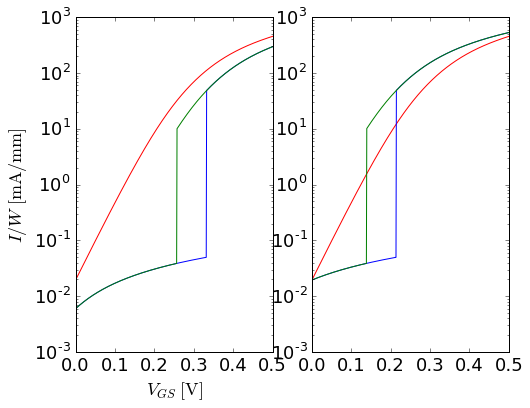

In [6]:
out=HTML()
vo2=None
fet2=None
hf=None
hf2=None
VTm,VTp=[None]*2
@interact(L=FloatSlider(value=20,min=1,max=45,step=1,continuous_update=False),
          W=FloatSlider(value=10,min=.5,max=20,step=.5,continuous_update=False),
          T=FloatSlider(value=10,min=.5,max=20,step=.5,continuous_update=False))
def show_hf(L,W,T):
    global vo2, fet2,VTm,VTp, hf, hf2
    plt.figure(figsize=(12,6))
    
    vo2=VO2(L=L*1e-9,W=W*1e-9,T=T*1e-9,**vo2_params)
    hf=HyperFET(fet,vo2)
    shift=appr.shift(hf,VDD)
    fet2=fet.shifted(shift)
    hf2=HyperFET(fet2,vo2)
    
    VD=np.array(VDD)
    VG=np.linspace(0,VDD,500)

    plt.subplot(131)
    I=np.ravel(fet.ID(VD=VD,VG=VG))
    plt.plot(VG,I/fet.W,'r')
    
    If,Ib=[np.ravel(i) for i in hf.I_double(VD=VD,VG=VG)]
    plt.plot(VG,If/fet.W,'b')
    plt.plot(VG,Ib/fet.W,'g')
    
    
    
    plt.ylim(1e-3,1e3)
    plt.xlabel("$V_{GS}\;\mathrm{[V]}$")
    plt.ylabel("$I/W\;\mathrm{[mA/mm]}$")
    ylog()
    
    plt.subplot(132)    
    plt.plot(VG,I/fet2.W,'r')
    If2,Ib2=[np.ravel(i) for i in hf2.I_double(VD=VD,VG=VG)]
    plt.plot(VG,If2/fet2.W,'b')
    plt.plot(VG,Ib2/fet2.W,'g')
    
    
    
    plt.ylim(1e-3,1e3)
    plt.yticks([])
    ylog()
    
    out.value="Approx shift is {:.2g}mV, which equates the IOFF within {:.2g}%."\
    "  This is expected to increase ION by {:.2g}% and actually increases it by {:.2g}%"\
    .format(shift*1e3,(If2[0]-I[0])/I[0]*100,appr.shiftedgain(hf,VDD)*100-100,(If2[-1]-I[-1])/I[-1]*100)
    
    _,_,VTm,VTp=appr.shorthands(hf,VDD,None,"VTm","VTp",gridinput=False)
    
display(out)

In [7]:
_,_,app_Ioff=appr.shorthands(hf,VDD,None,"app_Ioff",gridinput=False)

## Check Appr IOFF

In [8]:
app_Ioff/fet.ID(VDD,0)

1.0

In [9]:
hf.I(VDD,app_Ioff*vo2.R_ins*(1+fet.delta),Direction.FORWARD)/fet.ID(VDD,0)*100-100

-0.037457575290929412

## Check Appr ION

In [15]:
fet.k*(VDD-(fet.VT0-fet.delta*VDD))

4.625e-05

In [22]:
fet.Fsat(VDD,VDD)

0.9718467665907987

In [20]:
fet.ID(VDD,VDD)

array(4.5489429823471416e-05)

In [18]:
fet.ID(VDD,VDD)/(fet.k*(VDD-(fet.VT0-fet.delta*VDD)))

0.98355523942640899

In [19]:
fet.Ff(VDD,VDD)

0.03348986999252765

Ah so its because of slight non-saturation in inversion...